# Project 1: Understanding the Performance of Tree-based Models vs. Neural Networks for Tabular Data

Group members: Abou Keita and William Simpson \
Course: DATA690 - Practical Deep Learning \
Term: Fall 2022

# 1. Data Loading

Installations\
*Any dependency warnings do not affect the notebook*

In [ ]:
!pip install -q d2l
!pip install -q matplotlib_inline  # fix plotting issue
!pip install -q matplotlib==3.0  # needed to plot from d2l library

     |████████████████████████████████| 82 kB 509 kB/s 
     |████████████████████████████████| 9.9 MB 5.9 MB/s 
     |████████████████████████████████| 15.7 MB 54.8 MB/s 
     |████████████████████████████████| 61 kB 5.5 MB/s 
     |████████████████████████████████| 11.2 MB 33.3 MB/s 
     |████████████████████████████████| 120 kB 57.8 MB/s 
     |████████████████████████████████| 960 kB 29.8 MB/s 
     |████████████████████████████████| 1.6 MB 46.4 MB/s 
     |████████████████████████████████| 82 kB 256 kB/s 
     |████████████████████████████████| 12.8 MB 4.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.8.0 requires matplotlib>=

Downloading and Caching the Datasets

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
#download function downloads a dataset, caches it in a local directory (../data by default), and returns the name of the downloaded file
def download(name, cache_dir=os.path.join('..', 'data')):
  """Download a file inserted into DATA_HUB, return the local filename."""
  assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname # Hit cache
  print(f'Downloading {fname} from {url}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

In [ ]:
def download_extract(name, folder=None):
  """Download and extract a zip/tar file."""
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    fp = zipfile.ZipFile(fname, 'r')
  elif ext in ('.tar', '.gz'):
    fp = tarfile.open(fname, 'r')
  else:
    assert False, 'Only zip/tar files can be extracted.'
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data_dir

In [ ]:
def download_all():
  """Download all files in the DATA_HUB."""
  for name in DATA_HUB:
    download(name)

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score

In [ ]:
#download and cache the Kaggle housing dataset
DATA_HUB['kaggle_house_train'] = (
DATA_URL + 'kaggle_house_pred_train.csv',
'585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
DATA_URL + 'kaggle_house_pred_test.csv',
'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
# load training data only because test data lacks labels since it is from a competition
train_data = pd.read_csv(download('kaggle_house_train'))

# 2. Data Exploration

In [ ]:
# The training dataset includes 1460 examples, 80 features
print(train_data.shape)

(1460, 81)


In [ ]:
# preview data
train_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [ ]:
# preview target variable
train_data['SalePrice'].head(10)

0    208500
1    181500
2    223500
3    140000
4    250000
5    143000
6    307000
7    200000
8    129900
9    118000
Name: SalePrice, dtype: int64

In [ ]:
# number of features
print(len(train_data.columns))

81


In [ ]:
# describe the data
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [ ]:
# see null values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


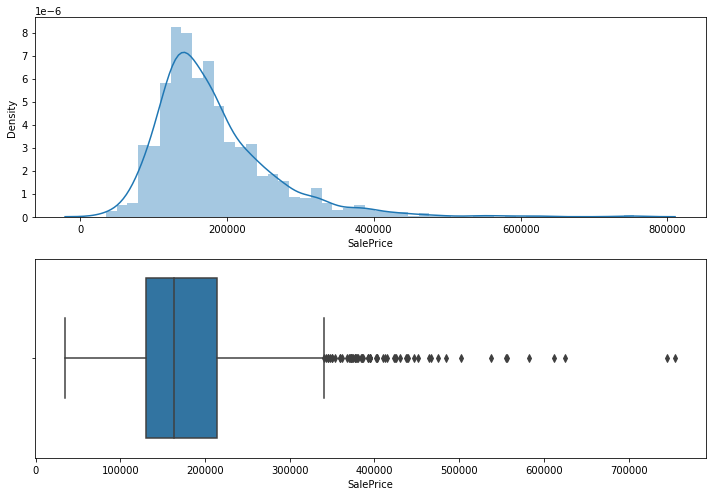

In [ ]:
# Visualize the dataset
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(train_data['SalePrice'])

fig.add_subplot(2,1,2)
sns.boxplot(train_data['SalePrice'])
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

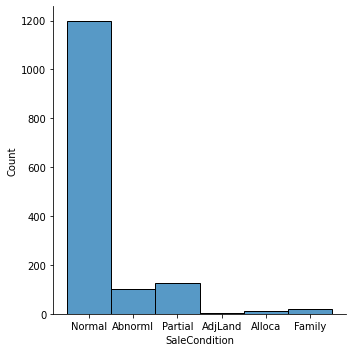

In [ ]:
fig = plt.figure(figsize=(10,10))
sns.displot(train_data['SaleCondition'])

# 3. Data Preprocessing

In [ ]:
# drop unnecessary column
train_data = train_data.drop(['Id'], axis=1)

In [ ]:
# remaining columns 
train_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [ ]:
# verify new shape
train_data.shape

(1460, 80)

Convert categorical features to one-hot encoding

In [ ]:
# Convert categorical variable into dummy/indicator variable
train_data = pd.get_dummies(train_data, dummy_na=True)
train_data.shape

(1460, 332)

In [ ]:
# count null values
train_data.isnull().sum().sum()

348

In [ ]:
# missing value imputation
train_data=train_data.fillna(train_data.mean())

In [ ]:
# verify no remaining null values
train_data.isnull().sum().sum()

0

Get features and target variable

In [ ]:
true_prices = train_data['SalePrice'].values
feature = train_data.drop(['SalePrice'], axis=1).values

In [ ]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
#numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
#train_data[numeric_features] = train_data[numeric_features].apply(
#lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
#train_data[numeric_features] = train_data[numeric_features].fillna(0)

Train test split

In [ ]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets with 20% test size for convention
X_train, X_test, Y_train, Y_test = train_test_split(feature, true_prices, test_size = 0.2, random_state = 45)

Scale the features using Standard Scaler

In [ ]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train.astype(float))
X_test = scale.transform(X_test.astype(float))

# 4. Model Building - Random Forest

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rfr = RandomForestRegressor(n_estimators = 1000, random_state = 45)
# Train the model on training data
rfr.fit(X_train, Y_train);

In [ ]:
# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 17768.99


In [ ]:
#compare actual output values with predicted values
y_pred = rfr.predict(X_test)

# evaluate the performance of the algorithm (MAE - MSE - RMSE)
print('MAE:', metrics.mean_absolute_error(Y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(Y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(Y_test,y_pred))

MAE: 17768.99419863014
MSE: 796715344.6813024
RMSE: 28226.146472398643
VarScore: 0.8789873188356354


In [ ]:
# view results
df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
df.head(10)

,Actual,Predicted
0,164700,162968.494
1,116000,115686.396
2,266000,312332.600
3,258000,283003.861
4,190000,220648.168
5,142500,139267.201
6,320000,280924.756
7,173000,191221.645
8,159895,180679.263
9,196000,184900.622


In [ ]:
# evaluate model using R2 Coefficient of Determination
R2_rf = rfr.score(X_test,Y_test)
print("R2 for Random Forest: ", R2_rf)

R2 for Random Forest:  0.8768654371569861


# 5. Model Building - Neural Network

In [ ]:
# convert data to tensors
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(Y_train).reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(Y_test).reshape(-1, 1), dtype=torch.float32)

In [ ]:
# define loss function and input shape
loss = nn.MSELoss()
in_features = X_train_tensor.shape[1]

In [ ]:
# define neural network structure
class NeuralNetwork(nn.Module):
        def __init__(self):
            """
            Specify NN layers and dimensions

            Defining the neural netowrk with 4 layers. 
            The train data has 331 features after converting categorical variable into dummy/indicator variable
            Input layer is determined by the feature shape of training data. 
            First hidden layer has 100 neurons, second hidden layer has size 50, output layer is size 1 which returns the house price prediction

            """
            super(NeuralNetwork, self).__init__()
            self.layer1 = nn.Linear(X_train.shape[1], 100) # input: feature.shape[1]=331, output: 400
            self.layer2 = nn.Linear(100, 50)
            self.layer3 = nn.Linear(50,1)
            
        # apply relu activation function to layers except output layer
        def forward(self, x):
            """
            Run feedforward with relu activation and return the ouput prediction
            """
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
            x = self.layer3(x)
            return x 

In [ ]:
# calculate loss
def log_rmse(net, features, labels):
    """
    Use log to stabilize loss value and complete loss calculation
    """
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [ ]:
# define training for NN
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    """
    Train the neural network and record the losses at each epoch
    """
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Adam optimization algorithm 
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
        print('training loss:', train_ls[epoch], '\ttest loss:', test_ls[epoch])
    return train_ls, test_ls

In [ ]:
# instatiate the model
nn_model = NeuralNetwork()

In [ ]:
# Train neural network
num_epochs = 30
learning_rate = .01
weight_decay = 0
batch_size = 64

train_loss, valid_loss = train(nn_model,
                               X_train_tensor, y_train_tensor,
                               X_test_tensor, y_test_tensor, 
                               num_epochs=num_epochs, 
                               learning_rate=learning_rate, 
                               weight_decay=weight_decay,
                               batch_size=batch_size)

training loss: 6.564260005950928 	test loss: 6.569410800933838
training loss: 4.233741283416748 	test loss: 4.233604431152344
training loss: 2.775049924850464 	test loss: 2.7731306552886963
training loss: 1.7665590047836304 	test loss: 1.764142394065857
training loss: 1.111897349357605 	test loss: 1.099915862083435
training loss: 0.7968236207962036 	test loss: 0.7387199401855469
training loss: 0.6962253451347351 	test loss: 0.5858216881752014
training loss: 0.6700600981712341 	test loss: 0.5024508833885193
training loss: 0.6389946341514587 	test loss: 0.4781678020954132
training loss: 0.6120234131813049 	test loss: 0.4563453197479248
training loss: 0.595125138759613 	test loss: 0.44237568974494934
training loss: 0.5808549523353577 	test loss: 0.4365875720977783
training loss: 0.5635830163955688 	test loss: 0.42670339345932007
training loss: 0.5511362552642822 	test loss: 0.41785743832588196
training loss: 0.5222497582435608 	test loss: 0.41171130537986755
training loss: 0.4980576336383

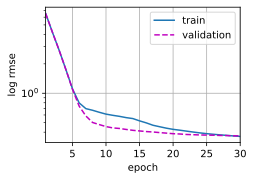

In [ ]:
# plot training and validation loss to evaluate the model
d2l.plot(np.arange(1, num_epochs + 1), [train_loss, valid_loss], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log', legend=['train', 'validation'])

In [ ]:
# get predictions for NN
y_pred = nn_model(X_test_tensor).detach().numpy()

In [ ]:
# Evaluate model and Compare to Random Forest with R2
R2_NN = r2_score(Y_test, y_pred)
print("R2 for Neural Network:", R2_NN)

R2 for Neural Network: 0.7489537389021572


# 6. Observations and Conclusions
- The R2 of the Random Forest is higher than the R2 of the Neural Network.
- This means that the Random Forest was better able to fit the tabular housing price data and produced a better regression model. 
- In other words, Random Forest was able to explain more of the variance in the dependent variable (house price) using the independent variables.